# Models Comparison for TinyML

In [21]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [22]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 0

In [23]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [24]:
n_labels = 2 + taskIndex
samples = 100
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [25]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [26]:
y = np.array([int(el) for el in y])
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(40, 42)
(40,)


In [28]:
X_test

array([[ 0.09,  0.02,  0.94,  0.07, -0.08,  0.96,  0.03, -0.05,  1.04,
         0.12,  0.07,  1.07,  0.08, -0.09,  0.72,  0.11, -0.12,  0.88,
         0.09, -0.23,  1.06,  0.1 , -0.03,  0.96,  0.08, -0.09,  0.98,
         0.08, -0.13,  0.98,  0.07, -0.15,  0.96,  0.11, -0.15,  0.96,
         0.07, -0.12,  1.01,  0.04, -0.27,  0.95],
       [-0.  ,  0.01,  0.97, -0.03,  0.06,  0.97, -0.08, -0.07,  1.32,
        -0.05, -0.38,  0.92,  0.11, -0.06,  0.73,  0.16,  0.24,  0.83,
         0.06,  0.11,  1.07,  0.03,  0.13,  1.07, -0.02,  0.04,  0.99,
        -0.08, -0.06,  0.93, -0.06,  0.02,  0.99, -0.04,  0.02,  1.  ,
        -0.02,  0.02,  0.98, -0.02,  0.  ,  0.98],
       [ 0.08,  0.03,  1.03,  0.05, -0.02,  0.98,  0.13,  0.35,  1.02,
         0.1 , -0.07,  1.15,  0.1 , -0.18,  1.01,  0.15,  0.07,  0.7 ,
         0.26,  0.2 ,  0.73,  0.15,  0.2 ,  0.93,  0.08,  0.21,  1.13,
        -0.  , -0.06,  1.  ,  0.04,  0.02,  1.04,  0.07, -0.03,  0.96,
         0.07,  0.01,  1.01,  0.07, -0.05,  0.

In [29]:
y_test

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## Model Spotting

In [30]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [31]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))


In [32]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,94 0,04
LR - 0,95 0,03
CART - 0,86 0,03
SVC - 0,99 0,02
RF - 0,96 0,03


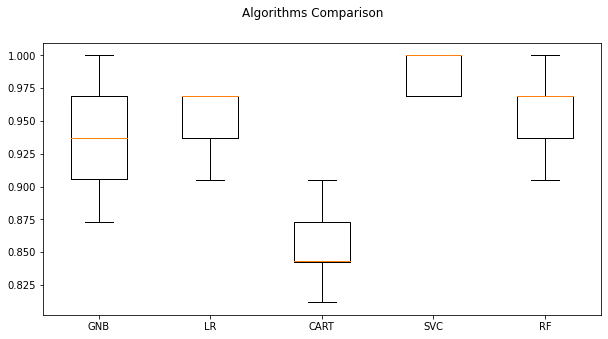

In [33]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [34]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy          

# Neural Network

In [35]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [ ]:
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
 
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 42)                1806      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 0s 545us/step - loss: 0.6980 - accuracy: 0.5000
Epoch 2/500
6/6 

6/6 [==============================] - 0s 394us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 154/500
6/6 [==============================] - 0s 413us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 155/500
6/6 [==============================] - 0s 471us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 156/500
6/6 [==============================] - 0s 396us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 157/500
6/6 [==============================] - 0s 389us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 158/500
6/6 [==============================] - 0s 481us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 159/500
6/6 [==============================] - 0s 481us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 160/500
6/6 [==============================] - 0s 435us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 161/500
6/6 [==============================] - 0s 416us/step - loss: 0.0153 - accuracy: 1.0000
Epoch 162/500
6/6 [==============================] - 0s 452us/step - loss: 0.0042 - accuracy: 1.0000
Epoc

6/6 [==============================] - 0s 385us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 313/500
6/6 [==============================] - 0s 380us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 314/500
6/6 [==============================] - 0s 505us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 315/500
6/6 [==============================] - 0s 464us/step - loss: 4.0871e-04 - accuracy: 1.0000
Epoch 316/500
6/6 [==============================] - 0s 420us/step - loss: 2.6192e-04 - accuracy: 1.0000
Epoch 317/500
6/6 [==============================] - 0s 396us/step - loss: 5.3029e-04 - accuracy: 1.0000
Epoch 318/500
6/6 [==============================] - 0s 495us/step - loss: 4.1972e-04 - accuracy: 1.0000
Epoch 319/500
6/6 [==============================] - 0s 416us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 320/500
6/6 [==============================] - 0s 377us/step - loss: 4.4469e-04 - accuracy: 1.0000
Epoch 321/500
6/6 [==============================] - 0s 440us/step - loss: 0.0022 - a

6/6 [==============================] - 0s 422us/step - loss: 0.0138 - accuracy: 1.0000
Epoch 469/500
6/6 [==============================] - 0s 400us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 470/500
6/6 [==============================] - 0s 486us/step - loss: 6.2143e-04 - accuracy: 1.0000
Epoch 471/500
6/6 [==============================] - 0s 431us/step - loss: 5.5048e-05 - accuracy: 1.0000
Epoch 472/500
6/6 [==============================] - 0s 441us/step - loss: 8.2681e-05 - accuracy: 1.0000
Epoch 473/500
6/6 [==============================] - 0s 408us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 474/500
6/6 [==============================] - 0s 483us/step - loss: 3.1172e-04 - accuracy: 1.0000
Epoch 475/500
6/6 [==============================] - 0s 413us/step - loss: 1.2544e-04 - accuracy: 1.0000
Epoch 476/500
6/6 [==============================] - 0s 406us/step - loss: 3.5223e-05 - accuracy: 1.0000
Epoch 477/500
6/6 [==============================] - 0s 430us/step - loss: 1.2472

6/6 [==============================] - 0s 393us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 120/500
6/6 [==============================] - 0s 402us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 121/500
6/6 [==============================] - 0s 402us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 122/500
6/6 [==============================] - 0s 391us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 123/500
6/6 [==============================] - 0s 447us/step - loss: 0.0145 - accuracy: 1.0000
Epoch 124/500
6/6 [==============================] - 0s 405us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 125/500
6/6 [==============================] - 0s 380us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 126/500
6/6 [==============================] - 0s 383us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 127/500
6/6 [==============================] - 0s 413us/step - loss: 0.0182 - accuracy: 1.0000
Epoch 128/500
6/6 [==============================] - 0s 413us/step - loss: 0.0284 - accuracy: 0.9737
Epoc

6/6 [==============================] - 0s 440us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 281/500
6/6 [==============================] - 0s 392us/step - loss: 0.0123 - accuracy: 1.0000
Epoch 282/500
6/6 [==============================] - 0s 428us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 283/500
6/6 [==============================] - 0s 477us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 284/500
6/6 [==============================] - 0s 441us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 285/500
6/6 [==============================] - 0s 400us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 286/500
6/6 [==============================] - 0s 493us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 287/500
6/6 [==============================] - 0s 476us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 288/500
6/6 [==============================] - 0s 395us/step - loss: 4.2595e-04 - accuracy: 1.0000
Epoch 289/500
6/6 [==============================] - 0s 368us/step - loss: 0.0023 - accuracy: 1.0000


6/6 [==============================] - 0s 383us/step - loss: 4.8057e-04 - accuracy: 1.0000
Epoch 439/500
6/6 [==============================] - 0s 499us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 440/500
6/6 [==============================] - 0s 480us/step - loss: 4.5809e-04 - accuracy: 1.0000
Epoch 441/500
6/6 [==============================] - 0s 398us/step - loss: 6.3215e-04 - accuracy: 1.0000
Epoch 442/500
6/6 [==============================] - 0s 382us/step - loss: 6.0157e-04 - accuracy: 1.0000
Epoch 443/500
6/6 [==============================] - 0s 493us/step - loss: 3.5756e-04 - accuracy: 1.0000
Epoch 444/500
6/6 [==============================] - 0s 449us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 445/500
6/6 [==============================] - 0s 450us/step - loss: 1.1996e-04 - accuracy: 1.0000
Epoch 446/500
6/6 [==============================] - 0s 424us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 447/500
6/6 [==============================] - 0s 446us/step - loss: 7.4118

6/6 [==============================] - 0s 401us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 90/500
6/6 [==============================] - 0s 372us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 91/500
6/6 [==============================] - 0s 482us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 92/500
6/6 [==============================] - 0s 468us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 93/500
6/6 [==============================] - 0s 414us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 94/500
6/6 [==============================] - 0s 434us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 95/500
6/6 [==============================] - 0s 505us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 96/500
6/6 [==============================] - 0s 437us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 97/500
6/6 [==============================] - 0s 372us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 98/500
6/6 [==============================] - 0s 386us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 99/500


6/6 [==============================] - 0s 512us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 248/500
6/6 [==============================] - 0s 560us/step - loss: 3.3231e-04 - accuracy: 1.0000
Epoch 249/500
6/6 [==============================] - 0s 399us/step - loss: 4.0780e-04 - accuracy: 1.0000
Epoch 250/500
6/6 [==============================] - 0s 447us/step - loss: 1.2856e-04 - accuracy: 1.0000
Epoch 251/500
6/6 [==============================] - 0s 512us/step - loss: 1.1290e-04 - accuracy: 1.0000
Epoch 252/500
6/6 [==============================] - 0s 466us/step - loss: 9.5100e-04 - accuracy: 1.0000
Epoch 253/500
6/6 [==============================] - 0s 408us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 254/500
6/6 [==============================] - 0s 512us/step - loss: 4.0677e-04 - accuracy: 1.0000
Epoch 255/500
6/6 [==============================] - 0s 446us/step - loss: 8.1012e-05 - accuracy: 1.0000
Epoch 256/500
6/6 [==============================] - 0s 407us/step - loss: 9.

6/6 [==============================] - 0s 464us/step - loss: 4.1301e-05 - accuracy: 1.0000
Epoch 404/500
6/6 [==============================] - 0s 408us/step - loss: 1.4862e-04 - accuracy: 1.0000
Epoch 405/500
6/6 [==============================] - 0s 374us/step - loss: 7.0884e-05 - accuracy: 1.0000
Epoch 406/500
6/6 [==============================] - 0s 495us/step - loss: 3.9324e-05 - accuracy: 1.0000
Epoch 407/500
6/6 [==============================] - 0s 468us/step - loss: 4.6549e-04 - accuracy: 1.0000
Epoch 408/500
6/6 [==============================] - 0s 385us/step - loss: 4.4736e-05 - accuracy: 1.0000
Epoch 409/500
6/6 [==============================] - 0s 393us/step - loss: 5.5310e-05 - accuracy: 1.0000
Epoch 410/500
6/6 [==============================] - 0s 462us/step - loss: 2.4012e-04 - accuracy: 1.0000
Epoch 411/500
6/6 [==============================] - 0s 456us/step - loss: 4.0829e-05 - accuracy: 1.0000
Epoch 412/500
6/6 [==============================] - 0s 449us/step - 

6/6 [==============================] - 0s 426us/step - loss: 0.0393 - accuracy: 1.0000
Epoch 53/500
6/6 [==============================] - 0s 393us/step - loss: 0.0647 - accuracy: 1.0000
Epoch 54/500
1/6 [====>.........................] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000

## Train and Test

In [36]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 42)                1806      
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 13,328
Trainable params: 13,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
18/18 [==============================] - 0s 4ms/step - loss: 0.7011 - accuracy: 0.5000 - val_loss: 0.72

18/18 [==============================] - 0s 1ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.2099 - val_accuracy: 0.9750
Epoch 52/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.2202 - val_accuracy: 0.9750
Epoch 53/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0190 - accuracy: 0.9917 - val_loss: 0.1855 - val_accuracy: 0.9750
Epoch 54/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9750
Epoch 55/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.2440 - val_accuracy: 0.9750
Epoch 56/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2081 - val_accuracy: 0.9750
Epoch 57/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.3213 - val_accuracy: 0.9250
Epoch 58/500
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9750
Epoch 109/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 0.9750
Epoch 110/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9917 - val_loss: 0.3556 - val_accuracy: 0.9000
Epoch 111/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.2910 - val_accuracy: 0.9250
Epoch 112/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.2045 - val_accuracy: 0.9750
Epoch 113/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2346 - val_accuracy: 0.9750
Epoch 114/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 0.9750
Epoch 115/500

18/18 [==============================] - 0s 1ms/step - loss: 2.0351e-04 - accuracy: 1.0000 - val_loss: 0.3173 - val_accuracy: 0.9500
Epoch 166/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0122 - accuracy: 0.9917 - val_loss: 0.1679 - val_accuracy: 0.9750
Epoch 167/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2806 - val_accuracy: 0.9500
Epoch 168/500
18/18 [==============================] - 0s 1ms/step - loss: 9.7115e-04 - accuracy: 1.0000 - val_loss: 0.2611 - val_accuracy: 0.9750
Epoch 169/500
18/18 [==============================] - 0s 1ms/step - loss: 7.8949e-04 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9750
Epoch 170/500
18/18 [==============================] - 0s 1ms/step - loss: 8.6925e-04 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9750
Epoch 171/500
18/18 [==============================] - 0s 1ms/step - loss: 8.3106e-04 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 

18/18 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2844 - val_accuracy: 0.9750
Epoch 222/500
18/18 [==============================] - 0s 1ms/step - loss: 5.9399e-04 - accuracy: 1.0000 - val_loss: 0.3074 - val_accuracy: 0.9500
Epoch 223/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2417 - val_accuracy: 0.9750
Epoch 224/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3379 - val_accuracy: 0.9500
Epoch 225/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 0.9917 - val_loss: 0.2987 - val_accuracy: 0.9500
Epoch 226/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0509 - accuracy: 0.9667 - val_loss: 0.3268 - val_accuracy: 0.9500
Epoch 227/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9750 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 228

Epoch 278/500
18/18 [==============================] - 0s 1ms/step - loss: 9.4757e-04 - accuracy: 1.0000 - val_loss: 0.3455 - val_accuracy: 0.9750
Epoch 279/500
18/18 [==============================] - 0s 1ms/step - loss: 8.2096e-04 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.9750
Epoch 280/500
18/18 [==============================] - 0s 1ms/step - loss: 1.2175e-04 - accuracy: 1.0000 - val_loss: 0.3334 - val_accuracy: 0.9750
Epoch 281/500
18/18 [==============================] - 0s 1ms/step - loss: 2.9964e-04 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9750
Epoch 282/500
18/18 [==============================] - 0s 1ms/step - loss: 9.0460e-05 - accuracy: 1.0000 - val_loss: 0.3381 - val_accuracy: 0.9750
Epoch 283/500
18/18 [==============================] - 0s 1ms/step - loss: 5.3203e-04 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 0.9750
Epoch 284/500
18/18 [==============================] - 0s 1ms/step - loss: 2.9062e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 334/500
18/18 [==============================] - 0s 1ms/step - loss: 6.1554e-04 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9750
Epoch 335/500
18/18 [==============================] - 0s 1ms/step - loss: 2.0715e-04 - accuracy: 1.0000 - val_loss: 0.3563 - val_accuracy: 0.9750
Epoch 336/500
18/18 [==============================] - 0s 1ms/step - loss: 1.5354e-04 - accuracy: 1.0000 - val_loss: 0.3619 - val_accuracy: 0.9750
Epoch 337/500
18/18 [==============================] - 0s 1ms/step - loss: 5.9518e-05 - accuracy: 1.0000 - val_loss: 0.3644 - val_accuracy: 0.9750
Epoch 338/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3977 - val_accuracy: 0.9750
Epoch 339/500
18/18 [==============================] - 0s 1ms/step - loss: 7.4914e-04 - accuracy: 1.0000 - val_loss: 0.3909 - val_accuracy: 0.9750
Epoch 340/500
18/18 [==============================] - 0s 1ms/step - loss: 2.9230e-04 - accuracy: 1.0000 - val_loss: 0.390

18/18 [==============================] - 0s 1ms/step - loss: 4.9009e-04 - accuracy: 1.0000 - val_loss: 0.6033 - val_accuracy: 0.9000
Epoch 391/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4544 - val_accuracy: 0.9500
Epoch 392/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3641 - val_accuracy: 0.9750
Epoch 393/500
18/18 [==============================] - 0s 1ms/step - loss: 3.2875e-04 - accuracy: 1.0000 - val_loss: 0.3561 - val_accuracy: 0.9750
Epoch 394/500
18/18 [==============================] - 0s 1ms/step - loss: 8.5223e-05 - accuracy: 1.0000 - val_loss: 0.3585 - val_accuracy: 0.9750
Epoch 395/500
18/18 [==============================] - 0s 1ms/step - loss: 5.1770e-04 - accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.9750
Epoch 396/500
18/18 [==============================] - 0s 1ms/step - loss: 2.0949e-04 - accuracy: 1.0000 - val_loss: 0.3789 - val_accuracy: 

18/18 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2797 - val_accuracy: 0.9750
Epoch 447/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 1.0324 - val_accuracy: 0.8250
Epoch 448/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9750 - val_loss: 0.3329 - val_accuracy: 0.9750
Epoch 449/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4337 - val_accuracy: 0.9250
Epoch 450/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0193 - accuracy: 0.9917 - val_loss: 0.3000 - val_accuracy: 0.9750
Epoch 451/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3587 - val_accuracy: 0.9750
Epoch 452/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4014 - val_accuracy: 0.9750
Epoch 453/500

In [37]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



# Export Models in C code

In [20]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpzr9uw3zf/assets
